使用条件对抗生成网络生成Cifar10数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/"
EPOCHS = 100
BATCH_SIZE = 128
IMAGE_SIZE = 32
IMAGE_CHANNEL = 3
NOISE_DIM = 100
LEARNING_RATE = 1e-3

In [2]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(NOISE_DIM + 10, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 256, 3, 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 3, 2),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, 3, 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 3, 2, output_padding=1),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc1(x)

        x = x.view(-1, 512, 1, 1)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)

        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 3, 2),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, 2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, 3, 2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, 3, 2),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(512 + 10, 256),
            torch.nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        self.merge_layer = torch.nn.Sequential(
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, input, label):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(-1, 512)
        x = torch.cat([x, label], 1)
        x = self.fc1(x)

        x = self.merge_layer(x)

        return x

# 3.导入数据

In [4]:
def one_hot(target):
    y = torch.zeros(target.size()[0], 10)

    for i in range(target.size()[0]):
        y[i, target[i]] = 1

    return y

trans = tv.transforms.Compose([tv.transforms.ToTensor()])
train_dataset = tv.datasets.CIFAR10(root=DATA_PATH, 
                                 train=True, 
                                 transform=trans,
                                 download=True)
train_loader=torch.utils.data.DataLoader(train_dataset,BATCH_SIZE,shuffle = True)

NetG = Generator()
NetD = Discriminator()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = torch.nn.BCELoss()

predict_noise = torch.randn(100, NOISE_DIM)
temp_z_ = torch.randn(10, 100)
Predict_y = torch.zeros(10, 1)
for i in range(9):
    temp = torch.ones(10, 1) + i
    Predict_y = torch.cat([Predict_y, temp], 0)

Predict_y = one_hot(Predict_y.long())

if torch.cuda.is_available():
    NetD = NetD.cuda()
    NetG = NetG.cuda()
    predict_noise = predict_noise.cuda()
    criterion.cuda()
    Predict_y = Predict_y.cuda()

Predict_Noise_var = torch.autograd.Variable(predict_noise)
Predict_y = torch.autograd.Variable(Predict_y)

Files already downloaded and verified


# 4.训练

In [5]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f, G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    if epoch % 10 == 0:
        optimizerG.param_groups[0]['lr'] /= 10
        optimizerD.param_groups[0]['lr'] /= 10

    for img_real, label_real in train_loader:
        mini_batch = label_real.shape[0]

        label_true = torch.ones(mini_batch)
        label_false = torch.zeros(mini_batch)
        label = one_hot(label_real.long().squeeze())
        noise = torch.randn(mini_batch, NOISE_DIM)

        if torch.cuda.is_available():
            label_true = label_true.cuda()
            label_false = label_false.cuda()
            img_real = img_real.cuda()
            label = label.cuda()
            noise = noise.cuda()

        label_true_var  = torch.autograd.Variable(label_true)
        label_false_var = torch.autograd.Variable(label_false)
        image_var       = torch.autograd.Variable(img_real)
        label_var       = torch.autograd.Variable(label)
        Noise_var = torch.autograd.Variable(noise)
        NetD.zero_grad()
        D_real = NetD(image_var, label_var)
        D_real_loss = criterion(D_real, label_true_var)

        image_fake = NetG(Noise_var, label_var)
        D_fake = NetD(image_fake, label_var)
        D_fake_loss = criterion(D_fake, label_false_var)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        optimizerD.step()

        NetG.zero_grad()
        image_fake = NetG(Noise_var,label_var)
        D_fake = NetD(image_fake,label_var)

        G_loss = criterion(D_fake, label_true_var)

        G_loss.backward()
        optimizerG.step()

        showbar.show(epoch, D_loss.item(), G_loss.item())

Epoch:1 / 100 [                                                                                                                                  ] 2 / 391 ,D Loss:1.369, G Loss:0.740,remain=0:04:25

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:2.068, G Loss:1.357,total=0:00:360
Epoch:2 / 100 [                                                                                                                                  ] 1 / 391 ,D Loss:0.918, G Loss:0.957,remain=4:03:17

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:2 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.999, G Loss:2.240,total=0:00:360
Epoch:3 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.988, G Loss:1.843,total=0:00:360
Epoch:4 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.895, G Loss:2.114,total=0:00:360
Epoch:5 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.945, G Loss:2.287,total=0:00:360
Epoch:6 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.609, G Loss:3.115,total=0:00:360


Epoch:41 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.202, G Loss:5.459,total=0:00:36054:0084
Epoch:42 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.053, G Loss:4.975,total=0:00:36032:5959
Epoch:43 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.375, G Loss:4.553,total=0:00:36011:5825
Epoch:44 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.117, G Loss:4.943,total=0:00:36050:3795
Epoch:45 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.

Epoch:80 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.168, G Loss:4.258,total=0:00:360:12:2080
Epoch:81 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.221, G Loss:5.025,total=0:00:360:31:285
Epoch:82 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.058, G Loss:4.977,total=0:00:350:50:319
Epoch:83 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:0.143, G Loss:3.965,total=0:00:410:05:0042
Epoch:84 / 100 [**********************************************************************************************************************************] 391 / 391 ,D Loss:

# 5.生成数据

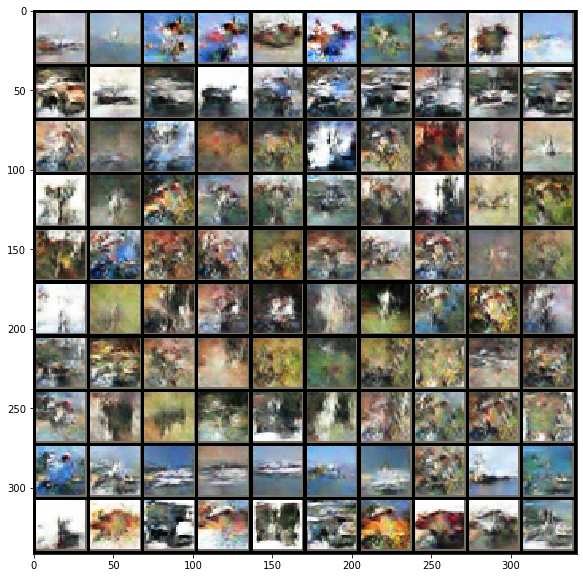

In [7]:
fake_u=NetG(Predict_Noise_var, Predict_y)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))